***
# <p style='text-align: center;'>`Tarea 3.2`</p>
***
`Elaborada por: Lyha Espinosa García, Ana Cristina Vázquez Vargas.` `Expedientes: if721861, if721215`


In [70]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web 
import warnings

In [71]:
datos = pd.read_csv("Data_OilCompany.csv", header=0)

In [72]:
data = pd.DataFrame(np.asmatrix(datos),
                    columns=['Year 1', 'Year 2', 'Year 3','Year 4', ' Year 5'])

Funcion NPV e IRR

In [73]:
def frame_inicial(datos,rf,precio,costo,costo_fijo,inversion):
    
    #Genera un data frame con la inversión inicial en negativo
    finicial=pd.DataFrame(columns=["Year 0"])
    for i in range(len(datos)):
        finicial.loc[i,"Year 0"]=-inversion
    
    #Genera un data frame con los flujos de efectivo
    data = pd.DataFrame(datos)
    for i in range(len(data)):
        for j in range(len(data.columns)):
            data.iloc[i,j]=(data.iloc[i,j])*(precio-costo)-costo_fijo
            
    #Union de los dataframes anteriores
    flujos = finicial.join(data)
    
    return flujos

In [74]:
def net_present_value(flujos,rf):
    NPV= pd.DataFrame(columns=["NPV"])
    for i in range(len(flujos)):
        rate, cashflows = rf,flujos.iloc[i,0:].to_list()
        NPV.loc[i,"NPV"]= np.npv(rate, cashflows).round(5)
    
    return NPV


In [75]:
def internal_interest_rate(flujos):
    IRR= pd.DataFrame(columns=["IRR"])
    for i in range(len(flujos)):
        cash = flujos.iloc[i,0:].to_list()
        IRR.loc[i,"IRR"]= np.irr(cash)
        
    return IRR

In [76]:
def resultados(npv,irr):
    return npv.join(irr)

Función Test Distributions

In [77]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
   # DISTRIBUTIONS = [        
      #  st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
       # st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        #st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
      #  st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
      #  st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
      #  st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
      #  st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
      #  st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
      #  st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
      #  st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    #]

  # Distributions to check
    DISTRIBUTIONS = [st.norm, st.uniform]


    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [78]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [79]:
def plot_dist(data, bins):
    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=200, density=True, alpha=0.5)
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'Data\n All Fitted Distributions')
    ax.set_xlabel(u'%')
    ax.set_ylabel('Frequency')
    
    plt.show()

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(u'Data with best fit distribution \n' + dist_str)
    ax.set_xlabel(u'%')
    ax.set_ylabel('Frequency')
    
    plt.show()

## Using the properties of random variables and knowing the PDF of the sales product of each year answer analytically:


### a) What are the expected product sales for year 1 and year 2?

Considerando que:
- $X$: Ventas año 1
- $Y$: Ventas año 2  

Sabemos que:  
$$ E[X + Y] = E[X] + E[Y] $$
Nuestra aproximación la haremos a partir de las esperanzas individuales de cada año, dado que cada serie se distribuye de diferente manera. 

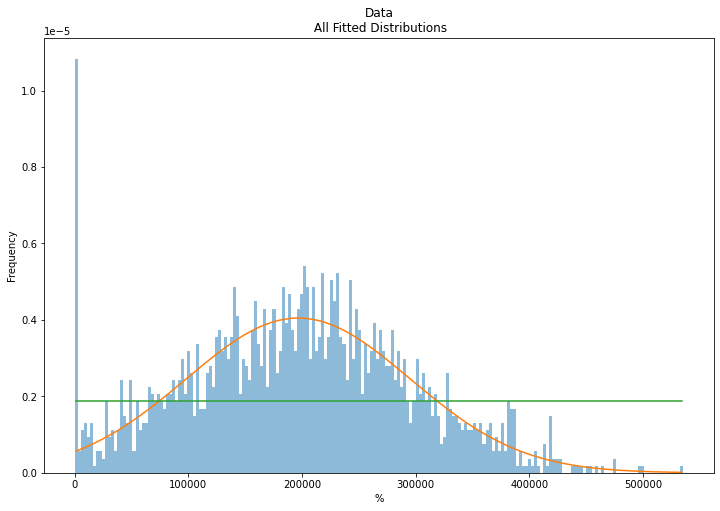

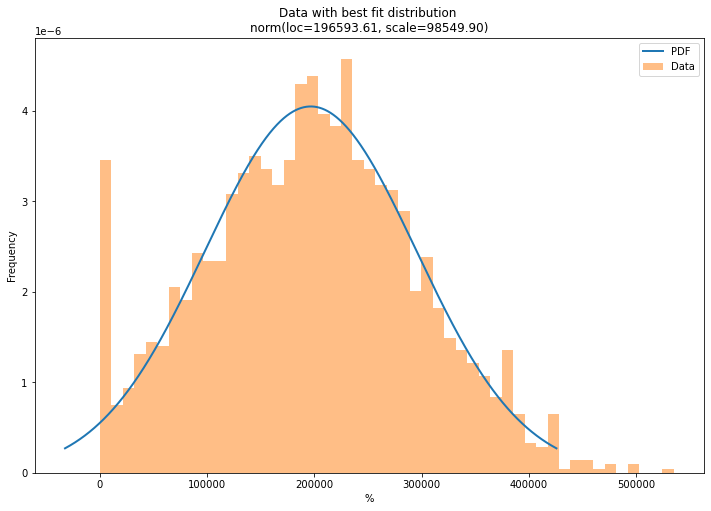

In [80]:
#Distribución año 1
plot_dist(data['Year 1'], bins=200)

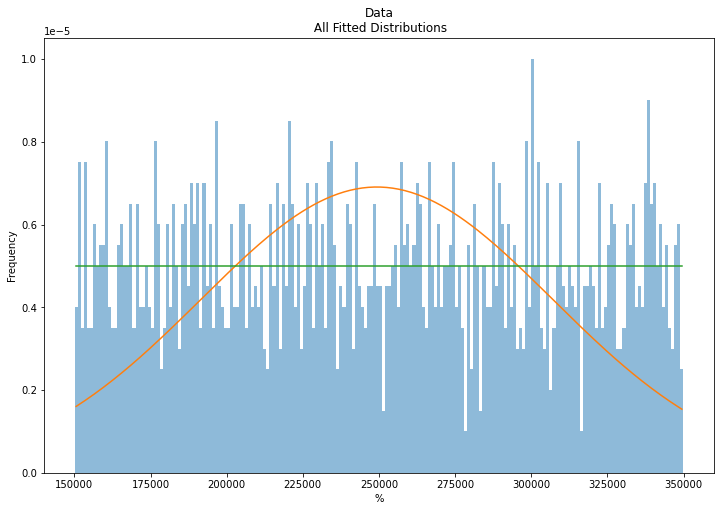

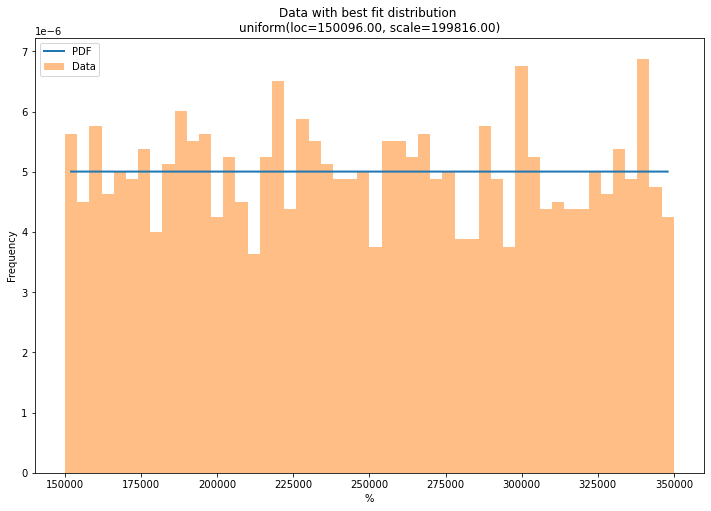

In [81]:
#Distribución año 2
plot_dist(data['Year 2'], bins=200)

Distribuciones:  
- Y1 ~ $N(\mu=196,593.61, \sigma=98,549.90)$
- Y2 ~ $U(a=150,096, b=349,912)$

Para la distribución normal: 
- Media =$\mu$
- Varianza =$\sigma^2$  

Para la distribución uniforme:
- Media =$\frac{1}{2}(a+b)$
- Varianza =$\frac{1}{12}(b-a)^2$  

Por lo tanto:  
$$E[Y1 + Y2]=\mu + \frac{1}{2}(a+b)$$  
Sustituimos: 
$$E[Y1 + Y2]=196,593.61 + \frac{1}{2}(150,096+349,912)$$
$$E[Y1 + Y2]= 446,597.61$$

### B)  What the expected revenue in PV for the life of the product? What is the VAR?

Dado que la vida del producto es de 5 años el **valor presente neto** sería:  
$VPN = -Inv + [\frac{y_1(P - C) - F}{(1 + r)^{1}}] + [\frac{y_2(P - C) - F}{(1 + r)^{2}}]+[\frac{y_3(P - C) - F}{(1 + r)^{3}}]+[\frac{y_4(P - C) - F}{(1 + r)^{4}}]+[\frac{y_5(P - C) - F}{(1 + r)^{5}}]$    
Donde:  
- $y_i$ = Variable estocastica (ventas por año)
- $P$ = Precio 
- $C$ = Costo 
- $F$ = Costo Fijo
- $r$ = Tasa libre de riesgo

Para calcular el valor esperado:  
$E[VPN] = E[-Inv + [\frac{y_1(P - C) - F}{(1 + r)^{1}}] + [\frac{y_2(P - C) - F}{(1 + r)^{2}}]+[\frac{y_3(P - C) - F}{(1 + r)^{3}}]+[\frac{y_4(P - C) - F}{(1 + r)^{4}}]+[\frac{y_5(P - C) - F}{(1 + r)^{5}}]]$  

Simplificando, sacamos las constantes   
$E[VPN] = -Inv + ((P - C) - F) * E[\frac{y_1}{(1 + r)^{1}} + \frac{y_2}{(1 + r)^{2}} + \frac{y_3}{(1 + r)^{3}} + \frac{y_4}{(1 + r)^{4}} + \frac{y_5}{(1 + r)^{5}}]$   
Aplicamos propiedxades del operador esperanza:  
$E[VPN] = -Inv + ((P - C) - F) * [E[\frac{y_1}{(1 + r)^{1}}] + E[\frac{y_2}{(1 + r)^{2}}]+E[\frac{y_3}{(1 + r)^{3}}]+E[\frac{y_4}{(1 + r)^{4}}]+E[\frac{y_5}{(1 + r)^{5}}]]$  
Nuevamente sacamos los valores constantes:  
$E[VPN] = -Inv + ((P - C) - F) * [\frac{1}{(1 + r)^{1}}E[y_1] + \frac{1}{(1 + r)^{2}}E[y_2]+\frac{1}{(1 + r)^{3}}E[y_3]+\frac{1}{(1 + r)^{4}}E[y_4]+\frac{1}{(1 + r)^{5}}E[y_5]]$   
Para poder sustituir en la ecuación y obtener el valor esperado necesitamos saber que distribución tiene cada serie (cada año) por medio de la función de máxima verosimilitud.   


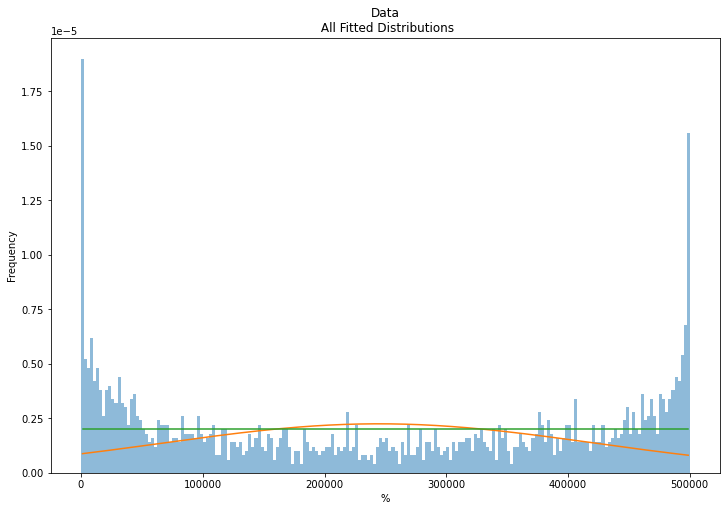

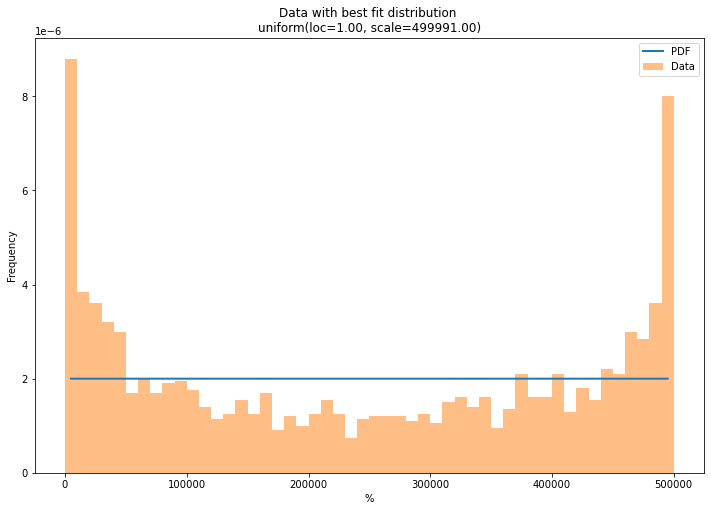

In [82]:
#Distribución año 3
plot_dist(data['Year 3'], bins=200)

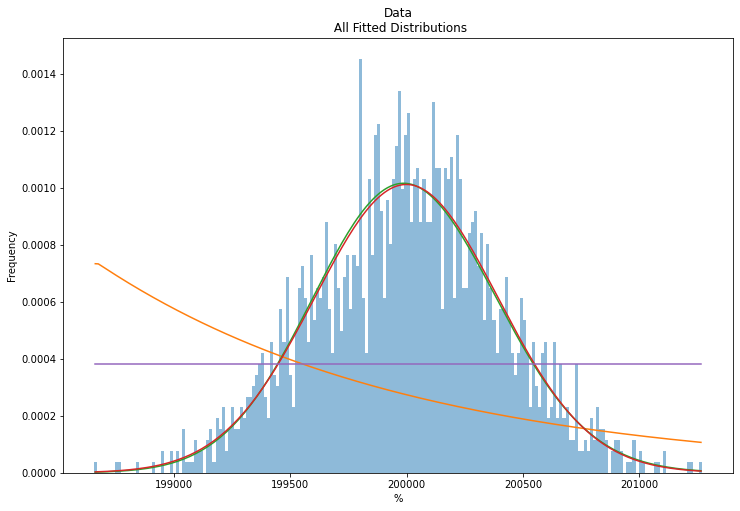

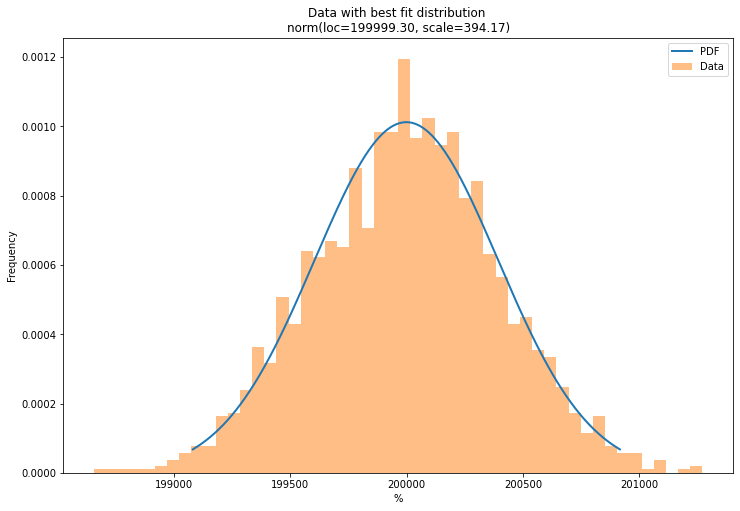

In [50]:
#Distribución año 4
plot_dist(data['Year 4'], bins=200)

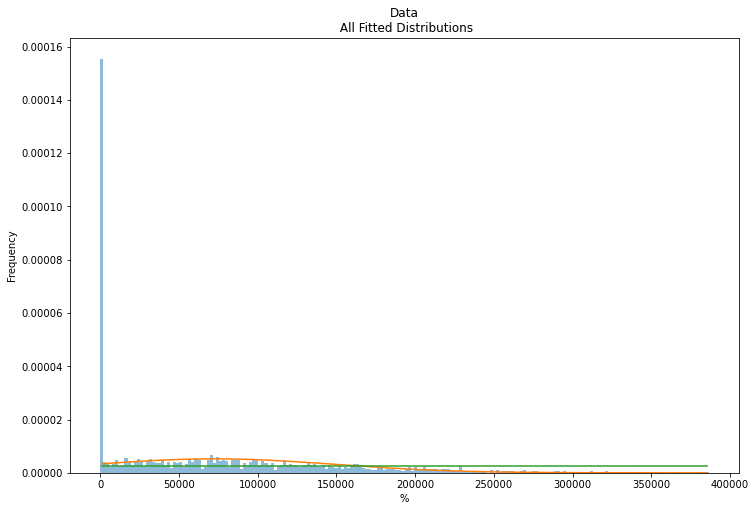

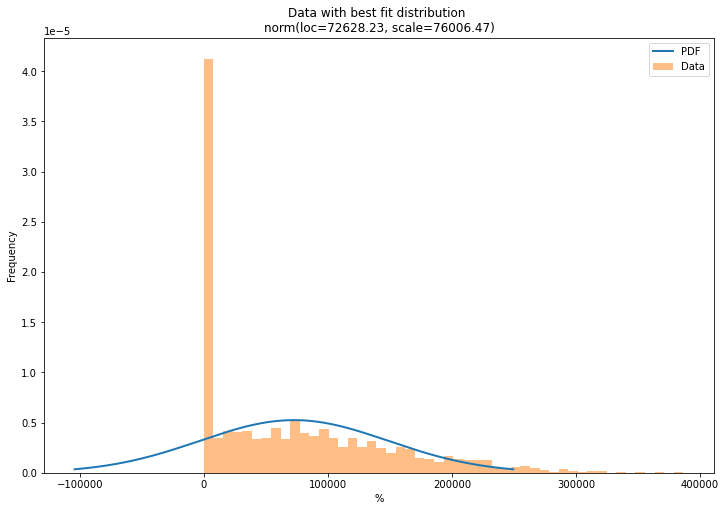

In [53]:
#Distribución año 5
plot_dist(data[' Year 5'], bins=200)

De lo anterior tenemos que las distribuciones son las siguientes: 
- Y1 ~ $N(\mu=196,593.61, \sigma=98,549.90)$
- Y2 ~ $U(a=150,096, b=349,912)$  
- Y3 ~ $U(a=1, b=499,992)$
- Y4 ~ $N(\mu=199,999.30, \sigma=394.17)$ 
- Y5 ~ $N(\mu=72,628.23, \sigma=76,006.47)$  

Para la distribución normal: 
- Media =$\mu$
- Varianza =$\sigma^2$  

Para la distribución uniforme:
- Media =$\frac{1}{2}(a+b)$
- Varianza =$\frac{1}{12}(b-a)^2$    

Por lo tanto para el valor esperado del **VPN**:  
$E[VPN] = -Inv + ((P - C) - F) * [\frac{1}{(1 + r)^{1}}E[y_1] + \frac{1}{(1 + r)^{2}}E[y_2]+\frac{1}{(1 + r)^{3}}E[y_3]+\frac{1}{(1 + r)^{4}}E[y_4]+\frac{1}{(1 + r)^{5}}E[y_5]]$    

Sustituimos: 
- $P$ = $\$5$ 
- $C$ = $\$0.8$ 
- $F$ = $\$40000$ 
- $r$ = $3\%$
- Inversion = $\$1800000$  

$E[VPN] = -1,800,000 + ((5 - 0.8) - 40,000) * [\frac{1}{(1.03)^{1}}E[y_1] + \frac{1}{(1.03)^{2}}E[y_2]+\frac{1}{(1.03)^{3}}E[y_3]+\frac{1}{(1.03)^{4}}E[y_4]+\frac{1}{(1.03)^{5}}E[y_5]]$    

De las distribuciones tenemos que:  
- $E[y_1] = 196,593.61$
- $E[y_2] = 250,004$
- $E[y_3] = 249,996.5$
- $E[y_4] = 199,999.30$
- $E[y_5] = 72,628.23$ 

$E[VPN] = -1,800,000 + ((5 - 0.8) - 40,000) * [\frac{196,593.61}{(1.03)^{1}} + \frac{250,004}{(1.03)^{2}}+\frac{249,996.5}{(1.03)^{3}}+\frac{199,999.30}{(1.03)^{4}}+\frac{72,628.23}{(1.03)^{5}}]$ 

$E[VPN] = -1,800,000 + [\frac{196,593.61 (5 - 0.8) - 40,000}{(1.03)^{1}} + \frac{250,004(5 - 0.8) - 40,000}{(1.03)^{2}}+\frac{249,996.5(5 - 0.8) - 40,000}{(1.03)^{3}}+\frac{199,999.30(5 - 0.8) - 40,000}{(1.03)^{4}}+\frac{72,628.23(5 - 0.8) - 40,000}{(1.03)^{5}}]$ 

$E[VPN] = [-1,800,000 + 762,808.895 + 952,037.704 + 924,279.623 + 710,787.026 + 228,624.595]$  

$E[VPN] = 1,778,537.844$

#### Varianza

$Var[VPN] = Var[-Inv + [\frac{y_1(P - C) - F}{(1 + r)^{1}}] + [\frac{y_2(P - C) - F}{(1 + r)^{2}}]+[\frac{y_3(P - C) - F}{(1 + r)^{3}}]+[\frac{y_4(P - C) - F}{(1 + r)^{4}}]+[\frac{y_5(P - C) - F}{(1 + r)^{5}}]]$  

Asumiendo que la covarianza entre las variables aleatorias es 0, no existe correlación entre ellas y que la varianza de una constante es 0:  
$Var[VPN] = Var[\frac{y_1(P - C) - F}{(1 + r)^{1}}] + Var[\frac{y_2(P - C) - F}{(1 + r)^{2}}]+Var[\frac{y_3(P - C) - F}{(1 + r)^{3}}]+Var[\frac{y_4(P - C) - F}{(1 + r)^{4}}]+Var[\frac{y_5(P - C) - F}{(1 + r)^{5}}]$ 

Simplificando y sacando las constantes:  
$Var[VPN] = \frac{(P-C)^2}{(1+r)^{1*2}}Var[y_1-F]+\frac{(P-C)^2}{(1+r)^{2*2}}Var[y_2-F]+\frac{(P-C)^2}{(1+r)^{3*2}}Var[y_3-F]+\frac{(P-C)^2}{(1+r)^{4*2}}Var[y_4-F]+\frac{(P-C)^2}{(1+r)^{5*2}}Var[y_5-F]$ 

Dado que al separar la expresión $Var[y_i-F]$ puede separarse en $Var[y_i]-Var[F]$ sabemos que la varianza de una constante es igual a 0 por tanto:  
$Var[VPN] = \frac{(P-C)^2}{(1+r)^{1*2}}Var[y_1]+\frac{(P-C)^2}{(1+r)^{2*2}}Var[y_2]+\frac{(P-C)^2}{(1+r)^{3*2}}Var[y_3]+\frac{(P-C)^2}{(1+r)^{4*2}}Var[y_4]+\frac{(P-C)^2}{(1+r)^{5*2}}Var[y_5]$   

Sustituimos:  
$Var[VPN] = \frac{(5.0.8)^2}{(1.03)^{2}}Var[y_1]+\frac{(5.0.8)^2}{(1.03)^{4}}Var[y_2]+\frac{(5.0.8)^2}{(1.03)^{6}}Var[y_3]+\frac{(5.0.8)^2}{(1.03)^{8}}Var[y_4]+\frac{(5.0.8)^2}{(1.03)^{10}}Var[y_5]$   

Dadas las funciones de distribución, sabemos que:  
- $Var[y_1]= 9,712,082,790.01$
- $Var[y_1]= 3,327,202,821.33$
- $Var[y_1]= 20,832,583,340.08$
- $Var[y_4]= 155,369.99$
- $Var[y_5]= 5,776,983,481.86$  

Sustituimos:  
$Var[VPN] =  \frac{17.64(9,712,082,790.01)}{(1.03)^{2}} + \frac{17.64(3,327,202,821.33)}{(1.03)^{4}} + \frac{17.64(20,832,583,340.08)}{(1.03)^{6}} + \frac{17.64(155,369.99)}{(1.03)^{8}} + \frac{17.64(5,776,983,481.86)}{(1.03)^{10}}$  

$Var[VPN]= 597,227,735,642.037$


### C) What the expected NPV and VAR for NPV?

In [83]:
#parametros
rf = .03
precio = 5
costo = 0.8
costo_fijo = 40000
inversion = 1800000

# valuacion del proyecto
flujos=frame_inicial(datos,rf,precio,costo,costo_fijo,inversion)
npv = net_present_value(flujos,rf)
irr = internal_interest_rate(flujos)
tabla = resultados(npv,irr)

<ipython-input-74-d680f33308d7>:5: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).
  NPV.loc[i,"NPV"]= np.npv(rate, cashflows).round(5)
<ipython-input-75-785c1e23d592>:5: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).
  IRR.loc[i,"IRR"]= np.irr(cash)


In [96]:
#Comparación de los resultados
comparacion = pd.DataFrame(columns=['E[Y]', 'var[Y]'], 
                           index = ['Analiticamente', 'Simulación'])
comparacion['E[Y]'] = [1778537.844, npv.mean()]
comparacion['var[Y]'] = [597227735642.037, npv.var()]
comparacion

,E[Y],var[Y]
Analiticamente,1.77854e+06,5.97228e+11
Simulación,NPV 1.754931e+06 dtype: float64,NPV 7.601918e+11 dtype: float64


### D) Estimate the PDF of NPV and IRR answer analytically:

Asumiendo que el NPV y IRR tienen una distribución normal, los parametros de estos serían:  

In [102]:
npv.mean()

NPV    1.754931e+06
dtype: float64

In [103]:
npv.var()

NPV    7.601918e+11
dtype: float64

In [99]:
irr.mean()

IRR    0.359257
dtype: float64

In [100]:
irr.var()

IRR    0.023968
dtype: float64

- $NVP ~ N(\mu=1.754931e+06, \sigma^2= 7.601918e+11)$
- $IRR ~ N(\mu=0.359257, \sigma^2=0.023968)$

#### 1. What the probability that the IRR is over the Risk free rate?

Al tener distribuciones normales, podemos saber la probabilidades usando la forma estandarizada:  
$$P(X>a) = 1-P(Z<\frac{a-\mu}{\sqrt{\sigma^2}})$$

Para la pregunta 1:  
$$P(X>0.03) = 1-P(Z<\frac{0.03-0.359257}{\sqrt{0.023968}})$$  
$$P(X>0.03) = 1-P(Z<-2.13)$$
Buscando en la 'tabla z': 
$$P(X>0.03) = 1 - 0.0166$$
$$P(X>0.03) = 98.34\%$$

#### 2. What the probability that the IRR is over the 35%?

$$P(X>0.35) = 1-P(Z<\frac{0.35-0.359257}{\sqrt{0.023968}})$$  
$$P(X>0.35) = 1-P(Z<-0.06)$$
Buscando en la 'tabla z': 
$$P(X>0.35) = 1 - 0.4761$$
$$P(X>0.35) = 52.39\%$$

#### 3. What the probability that the project value is over $2M?

$$P(X>2,000,000) = 1-P(Z<\frac{2,000,000-1,754,931}{\sqrt{ 7.601918e+11}})$$  
$$P(X>2,000,000) = 1-P(Z<0.28)$$
Buscando en la 'tabla z': 
$$P(X>2,000,000) = 1 - 0.6103$$
$$P(X>2,000,000) = 38.97\%$$

#### 4. What’s the probability that the IRR is between 10% and 20%?

$$P(0.10 < X < 0.20) = P(X < 0.20) - P(X < 0.10)$$
Probabilidad de $X<0.20$:  
$$P(X < 0.20) = P(Z<\frac{0.20-0.359257}{\sqrt{0.023968}})$$
$$P(X < 0.20) = P(Z<-1.03)$$
Buscando en la 'tabla z': 
$$P(X < 0.20) = 15.15\%$$

Probabilidad de $X<0.10$:  
$$P(X < 0.10) = P(Z<\frac{0.10-0.359257}{\sqrt{0.023968}})$$
$$P(X < 0.10) = P(Z<-1.67)$$
Buscando en la 'tabla z': 
$$P(X < 0.10) = 4.75\%$$

Con lo anterior sustituimos:  
$$P(0.10 < X < 0.20) = 15.15\% - 4.75\%$$
$$P(0.10 < X < 0.20) = 10.40\%$$

#### 5. Do you get same responses as in Homework 1.1?


Los resultados no son identicos a los de la tarea 1.1 en la cual las porbabilidades las obtuvimos implementando simulación, pero aunque no son igules si son respuestas muy similares, que se encuentran dentro del mismo rango, la diferencia son decimales.  
Esto puede ser por la variación de decimales al hacer los calculos analíticamente o simplemente porque hay una distribución que se ajusta mejor a los datos que tenemos y en este caso estamos asumiendo normalidad.  
